configuration:
models_ver - insert YOLO version's numbers that the UAP will be trained on.

epsilon, lambda_1, lambda_2 - attack's parameters. more information can be found in the [paper](https://arxiv.org/abs/2205.13618)

BDD_IMG_DIR - a path to the BDD validation set images (or any other wanted dataset)

BDD_LAB_DIR - a path to the BDD validation set labels (or any other wanted dataset)

In [1]:
models_vers = [5] # for example: models_vers = [5] or models_vers = [3, 4, 5]
epsilon = 70
lambda_1 = 1
lambda_2 = 10
seed = 42
patch_size=(640,640)
img_size=(640,640)
batch_size = 8
num_workers = 4
max_labels_per_img = 65
BDD_IMG_DIR = '/Users/coenschoof/miniconda/envs/phantomsponges/BDD100K-to-YOLOV5/bdd_in_YOLOV5_train_newLabels/images/val'
BDD_LAB_DIR = '/Users/coenschoof/miniconda/envs/phantomsponges/BDD100K-to-YOLOV5/bdd_in_YOLOV5_train_newLabels/labels/val'

Load BDD dataset:

In [2]:
import torch
import os
import random
import numpy

from datasets.augmentations1 import train_transform
from datasets.split_data_set_combined import SplitDatasetCombined_BDD

/Users/coenschoof/miniconda/envs/phantomsponges/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# batch = [(1, 'a'), (2, 'b'), (3, 'c')]

# unzipped = zip(*batch)

# numbers, letters = unzipped

# print(numbers)  # Output: (1, 2, 3)
# print(letters)  # Output: ('a', 'b', 'c')

#dus ipv [(tensor, array, string), (tensor, array, string), (tensor, array, string)] hebben we
# train_loader[0] bevat 8 images
# train_loader[1] bevat alle labels per voor 8 images
# train_loader[2] bevat paths naar 8 images
def collate_fn(batch):
    return tuple(zip(*batch))

def set_random_seed(seed_value, use_cuda=True):
    numpy.random.seed(seed_value)  # cpu vars
    torch.manual_seed(seed_value)  # cpu  vars
    random.seed(seed_value)  # Python
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # Python hash buildin
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # gpu vars
        torch.backends.cudnn.deterministic = True  # needed
        torch.backends.cudnn.benchmark = False

In [4]:
split_dataset = SplitDatasetCombined_BDD(
            img_dir= BDD_IMG_DIR,
            lab_dir= BDD_LAB_DIR,
            max_lab=max_labels_per_img,
            img_size=img_size,
            transform=train_transform,
            collate_fn=collate_fn)

In [5]:
#train_loader en val_loader 

#train loader bevat een tuple van 3, elk element van de tuple bevat 8 samples (8 samples maakt 1 batch)
#De tuple bestaat uit het volgende:
    #[0] = de image met size (3,640,640)
    #[1] = de bounding boxes met size (x, 5) (5 bestaat uit class, x, y, x, y)
        #lijkt nergens gebruikt te worden
    #[2] = de naam van de image (e.g. 'c98258a4-54a47ff2.jpg')  

    #HEB IK AL DEZE INFORMATIE OOK NODIG WANNEER IK WIL TESTEN OP PASCAL/MTSD? converten is een pain
        #WORDT [2] ERGENS GEBRUIKT? IK WEET DAT [1] NERGENS GEBRUIKT WORDT
train_loader, val_loader, test_loader = split_dataset(val_split=0.1,
                                                      shuffle_dataset=True,
                                                      random_seed=seed,
                                                      batch_size=batch_size,
                                                      ordered=False,
                                                      collate_fn=collate_fn)

In [19]:
# from torch.utils.data import DataLoader, SubsetRandomSampler, RandomSampler

# sampler = RandomSampler([0,1,2,3])

# for i in sampler:
#     print(i)

In [20]:
# next(iter(train_loader))

In [21]:
# clean_xyxy_out = torch.tensor([[0.0156, 0.0312, 0.0781, 0.1094]])

# patch_xyxy_out = torch.tensor([
#                         [10/640, 20/640, 50/640, 70/640],  # [x1, y1, x2, y2]
#                         [30/640, 40/640, 80/640, 100/640],
#                         [60/640, 70/640, 120/640, 160/640],
#                     ])

# #intersect(patch_xyxy_out, clean_xyxy_out)

# torch.min(clean_xyxy_out[:, 2:].unsqueeze(1).expand(1, 3, 2), patch_xyxy_out[:, 2:].unsqueeze(0).expand(1, 3, 2))

In [22]:
# import torch
# import torchvision.transforms as transforms
# from PIL import Image

# # Load the image using PIL
# image = Image.open('/Users/coenschoof/miniconda/envs/phantomsponges/BDD100K-to-YOLOV5/bdd100k/images/100k/val/b1c9c847-3bda4659.jpg')

# # Define the transformations to apply to the image
# transform = transforms.ToTensor()

# # Apply the transformations to convert the image to a tensor
# tensor = transform(image)

In [23]:
# model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# # Inference
# results = model(tensor.unsqueeze(0))

In [24]:
# results.size()

In [25]:
# for (img_batch, lab_batch, _) in val_loader:
#     print(torch.stack(img_batch).size())
#     break


create UAP:

In [6]:
import numpy
from attack.uap_phantom_sponge import UAPPhantomSponge

torch.cuda.empty_cache()

patch_name = r"yolov"
for ver in models_vers:
  patch_name += f"_{ver}"
patch_name += f"_epsilon={epsilon}_lambda1={lambda_1}_lambda2={lambda_2}"

uap_phantom_sponge_attack = UAPPhantomSponge(patch_folder=patch_name, 
                                             train_loader=train_loader, 
                                             val_loader=val_loader, 
                                             epsilon = epsilon, 
                                             lambda_1=lambda_1, 
                                             lambda_2=lambda_2, 
                                             #epochs=7,#stond hier voorheen nog niet
                                             patch_size=patch_size, 
                                             models_vers=models_vers)
adv_img = uap_phantom_sponge_attack.run_attack()

CUDA Available:  False
local_yolos/yolov5/weights/yolov5s.pt


Fusing layers... 
[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.
yolov5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs


Epoch:  0
Transformed Image Shape: torch.Size([3, 640, 640])
Transformed Image Shape: torch.Size([3, 640, 640])
Transformed Image Shape: torch.Size([3, 640, 640])
Transformed Image Shape: torch.Size([3, 640, 640])
Transformed Image Shape: torch.Size([3, 640, 640])
Transformed Image Shape: torch.Size([3, 640, 640])
Transformed Image Shape: torch.Size([3, 640, 640])
Transformed Image Shape: torch.Size([3, 640, 640])
saving png of current patch at epoch: 0, batch: 0/169...


KeyboardInterrupt: 

# CODE FOR EVALUATION

In [182]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from local_yolos.yolov5.models.experimental import attempt_load
from local_yolos.yolov5.utils.general import non_max_suppression
from torchvision import transforms
from local_yolos.yolov5.utils.metrics import box_iou
import time
from tqdm import tqdm

In [8]:
# Load the YOLOv5 model
model = attempt_load(weights='yolov5s.pt').eval()

yolov5s.pt


100%|██████████| 14.1M/14.1M [00:00<00:00, 23.7MB/s]

Fusing layers... 
[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.
yolov5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs


In [297]:
def perturb_img(img_name, change_aspect_ratio = True):
    image_path = "/Users/coenschoof/miniconda/envs/phantomsponges/BDD100K-to-YOLOV5/bdd_in_YOLOV5_train_newLabels/images/val/" + img_name
    image = Image.open(image_path)
    image = image.resize((640, 640))
    transform = transforms.Compose([transforms.ToTensor()])
    clean_img = transform(image)

    # Load the image using PIL
    patch_path =  "/Users/coenschoof/miniconda/envs/phantomsponges/PhantomSponges/final_patch.png"
    patch = Image.open(patch_path)
    patch = transform(patch)

    perturbed_img = torch.clamp(clean_img + patch, 0, 1)

    # Assuming you have a torch tensor named torch_image
    # You can resize the tensor to (H, W, C) shape using transpose and multiply by 255 (if it's not already in the correct range)
    #pil_image = transforms.ToPILImage()(result.squeeze().cpu() * 255)
    tensor_min = torch.min(perturbed_img)
    tensor_max = torch.max(perturbed_img)
    normalized_tensor = (perturbed_img - tensor_min) / (tensor_max - tensor_min)

    # Convert the normalized tensor to a PIL image
    pil_image = transforms.ToPILImage()(normalized_tensor.squeeze().cpu())
    if change_aspect_ratio:
        random_scale_w = random.uniform(0.5, 2)
        random_scale_h = random.uniform(0.5, 2)
        width = int(640 * random_scale_w)
        height = int(640 * random_scale_h)
        pil_image = pil_image.resize((width, height))
    perturbed_image_tensor = transform(pil_image)

    return(perturbed_image_tensor)

In [ ]:
def compute_recall(box_iou_output):
    true_pos = 0
    for clean_detection in box_iou_output:
        if clean_detection[clean_detection > 0.45].nelement() != 0:
            true_pos += 1

    return true_pos / box_iou_output.size()[0]

In [343]:
import cv2

interp = cv2.INTER_LINEAR if r > 1 else cv2.INTER_AREA
im = cv2.resize(im, (int(w0 * r), int(h0 * r)), interpolation=interp)

NameError: name 'r' is not defined

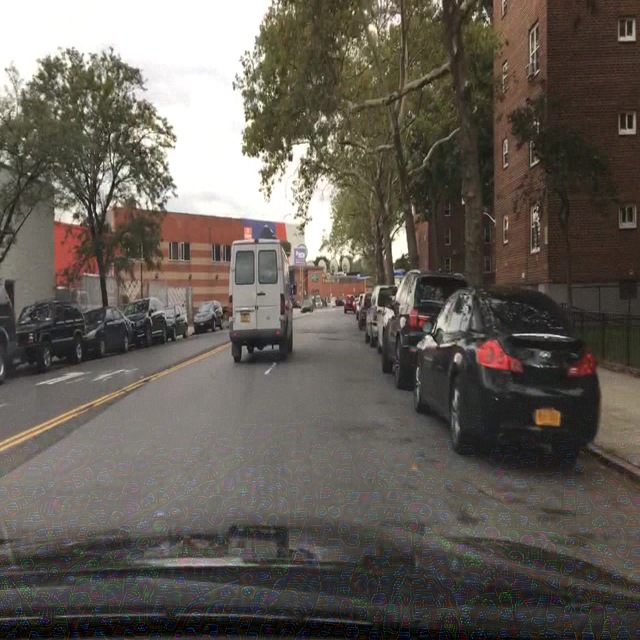

In [339]:
some_image = perturb_img('b1c9c847-3bda4659.jpg', False).unsqueeze(0)
pil_image = transforms.ToPILImage()(some_image.squeeze().cpu())
display(pil_image)

In [340]:
print(some_image.shape)

torch.Size([1, 3, 640, 640])


In [341]:
model(some_image)

(tensor([[[3.25666e+00, 3.31778e+00, 7.12027e+00,  ..., 1.22970e-03, 5.17618e-04, 2.14381e-03],
          [1.10366e+01, 3.70846e+00, 2.25475e+01,  ..., 1.34437e-03, 7.10199e-04, 2.31068e-03],
          [1.84925e+01, 3.98835e+00, 2.93835e+01,  ..., 1.13451e-03, 7.25381e-04, 3.55165e-03],
          ...,
          [5.56226e+02, 6.00935e+02, 1.43809e+02,  ..., 1.29265e-03, 3.60382e-04, 3.96700e-04],
          [5.89583e+02, 6.06432e+02, 1.37473e+02,  ..., 1.21622e-03, 3.38053e-04, 4.56440e-04],
          [6.17760e+02, 6.17646e+02, 1.33568e+02,  ..., 1.06142e-03, 5.48852e-04, 9.68742e-04]]]),
 [tensor([[[[[-1.86373e-01, -1.70971e-01, -3.14944e-01,  ..., -6.69975e+00, -7.56575e+00, -6.14302e+00],
             [-2.42032e-01, -7.29173e-02,  1.10283e+00,  ..., -6.61048e+00, -7.24925e+00, -6.06790e+00],
             [-3.81444e-01, -2.91342e-03,  1.79125e+00,  ..., -6.78042e+00, -7.22809e+00, -5.63679e+00],
             ...,
             [ 1.02078e-01,  7.71405e-02,  1.89526e+00,  ..., -6.13359e+0

In [322]:
def evaluate_results(loader = test_loader, Tconf = 0.25, Tiou = 0.45, max_det_pert=300, max_det_clean=300):
    all_total_times = []
    all_nms_times = []
    all_num_bbs_before_nms = []
    all_recalls = []

    for image_np, _, image_name in tqdm(loader):
        #EXPERIMENTEER MET DE ASPECT RATIO VERANDEREN, KIJK HIERVOOR IN DE CODE OP HET CLUSTER
        #HET LIJKT NIET TE WERKEN, model() MOET DE IMAGES AANGELEVERD KRIJGEN IN 640X640
        #LIJKT ER DUS OP DAT MIJN VERDEDIGING WERKT DOOR DE PREPROCESSING NAAR 640X640
        #ZIJN DAT NOG WEL GELDIGE RESULTATEN? MOET HET NIET PER SE model() ZIJN IPV detect.py?
        perturbed_img = perturb_img(image_name[0]).unsqueeze(0)
        clean_img = image_np[0].unsqueeze(0)
        
        #VOLGENS HET PAPER MOET HET 30 ITERS FOR EACH IMAGE ZIJN, DAARVAN AVG
        #ALLEEN DE TIME OF OOK MEER?
        start_time_1 = time.time() * 1000
        output_perturbed = model(perturbed_img)[0]
        start_time_2 = time.time() * 1000
        keep_perturbed = non_max_suppression(output_perturbed, Tconf, Tiou, classes=None,max_det=max_det_pert)
        #print(len(keep_perturbed[0]))
        end_time = time.time() * 1000 
        total_time = end_time - start_time_1
        nms_time = end_time - start_time_2
        #print(nms_time)

        output_clean = model(clean_img)[0]
        keep_clean = non_max_suppression(output_clean, Tconf, Tiou, classes=None,max_det=max_det_clean)

        num_bbs_before_nms_mask = output_perturbed[..., 4] > Tconf 
        num_bbs_before_nms = num_bbs_before_nms_mask.sum().item()   #F(C')

        clean_xyxy = keep_clean[0][:,0:4]
        perturbed_xyxy = keep_perturbed[0][:,0:4]
        box_iou_output = box_iou(clean_xyxy, perturbed_xyxy)
        
        #check if its the case that there aren't any clean detections
        #in that case, skip computing the recall
        #"the number of original objects detected in the perturbed image"
        #if there aren't any original objects, no recall can be calculated, thus we skip
        if clean_xyxy.nelement() != 0:
            recall = compute_recall(box_iou_output)
            all_recalls.append(recall)

        all_total_times.append(total_time)
        all_nms_times.append(nms_time)
        all_num_bbs_before_nms.append(num_bbs_before_nms)
        

    avg_total_time = sum(all_total_times) / len(all_total_times)
    avg_nms_time = sum(all_nms_times) / len(all_nms_times)
    avg_num_bbs_before_nms = sum(all_num_bbs_before_nms) / len(all_num_bbs_before_nms)
    avg_recall = sum(all_recalls) / len(all_recalls)

    return round(avg_total_time, 1), round(avg_nms_time, 1), round(avg_num_bbs_before_nms), round(avg_recall, 3)

results = evaluate_results()

  0%|          | 0/500 [00:00<?, ?it/s]


RuntimeError: torch.cat(): Sizes of tensors must match except in dimension 1. Got 44 and 43 in dimension 2 (The offending index is 1)

In [ ]:
results

In [268]:
results

(505.1, 4.3, 4500, 0.656)

In [187]:
results

(509.6, 4.3, 4500, 0.656)